# Approach 3: Basis Function Gaussian Process

   - **Method**: The input space is partitioned into overlapping regions, each modeled by a local Gaussian Process (GP) weighted by orthogonal basis functions.
   - **Implementation**: Use a mixture-of-GPs, where different regions have different length-scales, and the basis functions are smooth, orthogonal functions that sum to one across the domain.
   - **Pros**:
     - Smooth transitions between local GPs avoid sharp discontinuities at region boundaries.
   - **Cons**:
     - Potential oversmoothing of length-scale variations.

In [1]:
# Imports

import gpytorch
import plotly.graph_objects as go
import torch
from IPython.display import Image
from plotly import subplots

import utils

image_type = "static"  # html / static

In [2]:
# Load input data

filename_identifier = "B"

# Target data files
filename_true = f"data/true_data_{filename_identifier}.csv"
filename_obs = f"data/observed_data_{filename_identifier}.csv"

# Load as tensors
true_x, true_y, obs_x, obs_y = utils.load_true_and_obs_tensors(
    filename_true,
    filename_obs,
)

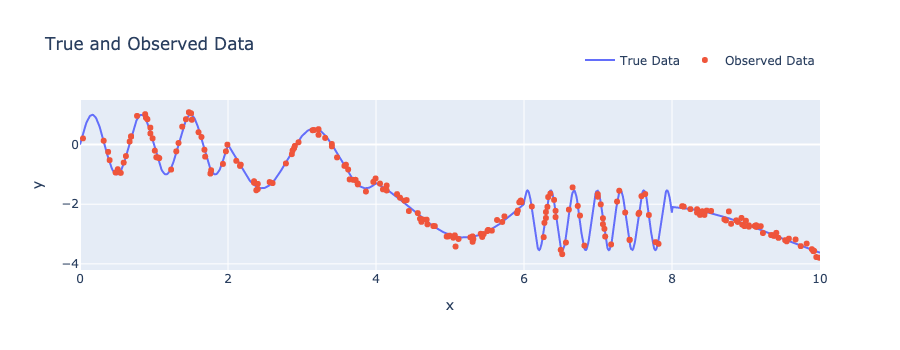

In [3]:
# Plot the data

fig = go.Figure()

# Plot true function and sampled noisy data
fig.add_trace(go.Scatter(x=true_x, y=true_y, mode="lines", name="True Data"))
fig.add_trace(go.Scatter(x=obs_x, y=obs_y, mode="markers", name="Observed Data"))

# Update layout
fig.update_xaxes(range=[0, 10])
fig.update_layout(title="True and Observed Data", xaxis_title="x", yaxis_title="y")
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.15, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))

## Method: Basis-Function Gaussian Process Model

In [4]:
# Define the model, likelihood, and additional model components


def triangular_basis(x, centers, width):
    """Compute triangular basis function values for each center."""
    return torch.clamp(1 - torch.abs(x.unsqueeze(1) - centers) / width, min=0)


class ExactGPModel(gpytorch.models.ExactGP):
    """Stationary-kernel GP model for each basis function. Uses RBF kernel for simplicity."""

    def __init__(self, train_x, train_y):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class BasisWeightedGP:
    """A Gaussian Process model that uses a weighted combination of basis functions and
    fits a separate GP for each basis function region."""

    def __init__(self, train_x, train_y, num_basis=5, width=2.0):
        self.train_x, self.train_y = train_x, train_y
        self.num_basis = num_basis
        self.width = width
        self.centers = torch.linspace(train_x.min(), train_x.max(), num_basis)
        self.basis_functions = triangular_basis(train_x, self.centers, width)
        self.models = []
        self.likelihoods = []

        # Train individual GPs for each basis function
        for i in range(num_basis):
            mask = self.basis_functions[:, i] > 0
            if mask.sum() > 1:
                model = ExactGPModel(train_x[mask], train_y[mask])
                likelihood = gpytorch.likelihoods.GaussianLikelihood()
                likelihood.noise_covar.noise = 0.011
                self.models.append((model, likelihood))
            else:
                self.models.append(None)

    def train(self, training_iter=100):
        for model, likelihood in self.models:
            if model is not None:
                model.train()
                likelihood.train()
                optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
                mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

                for i in range(training_iter):
                    optimizer.zero_grad()
                    output = model(model.train_inputs[0])
                    loss = -mll(output, model.train_targets)
                    loss.backward()
                    optimizer.step()
                    if i % 10 == 0:
                        print(f"Iter {i}: Loss = {loss.item():.3f}")

    def predict(self, test_x, n_samples=10):
        basis_vals = triangular_basis(test_x, self.centers, self.width)
        pred_means = torch.zeros_like(test_x)
        pred_vars = torch.zeros_like(test_x)

        for i, (model, likelihood) in enumerate(self.models):
            if model is not None:
                model.eval()
                likelihood.eval()
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    pred_dist = likelihood(model(test_x))
                    pred_means += basis_vals[:, i] * pred_dist.mean
                    pred_vars += basis_vals[:, i] * pred_dist.variance

        # Posterior samples
        samples = torch.zeros(test_x.shape[0], n_samples)
        basis_functions = triangular_basis(test_x, self.centers, self.width)
        for i in range(n_samples):
            for j, (model, likelihood) in enumerate(self.models):
                mask = basis_functions[:, j] > 0
                if model is not None:
                    model.eval()
                    likelihood.eval()
                    with torch.no_grad(), gpytorch.settings.fast_pred_var():
                        pred_dist = model(test_x[mask])
                        samples[mask, i] += basis_vals[mask, j] * pred_dist.sample()

        # Confidence intervals
        pred_upper = pred_means + 2 * torch.sqrt(pred_vars)
        pred_lower = pred_means - 2 * torch.sqrt(pred_vars)

        return pred_means, pred_upper, pred_lower, samples

In [5]:
# Initialize likelihood and model

num_basis = 11
width = 1.0
basis_gp = BasisWeightedGP(obs_x, obs_y, num_basis=num_basis, width=width)
basis_functions_true = triangular_basis(true_x, basis_gp.centers, basis_gp.width)

In [6]:
# Train the model

n_epochs = 300
basis_gp.train(training_iter=n_epochs)

Iter 0: Loss = 9.625
Iter 10: Loss = 0.372
Iter 20: Loss = -0.186
Iter 30: Loss = -0.117
Iter 40: Loss = -0.119
Iter 50: Loss = -0.159
Iter 60: Loss = -0.214
Iter 70: Loss = -0.258
Iter 80: Loss = -0.282
Iter 90: Loss = -0.288
Iter 100: Loss = -0.288
Iter 110: Loss = -0.288
Iter 120: Loss = -0.289
Iter 130: Loss = -0.289
Iter 140: Loss = -0.289
Iter 150: Loss = -0.290
Iter 160: Loss = -0.290
Iter 170: Loss = -0.290
Iter 180: Loss = -0.290
Iter 190: Loss = -0.291
Iter 200: Loss = -0.291
Iter 210: Loss = -0.291
Iter 220: Loss = -0.291
Iter 230: Loss = -0.291
Iter 240: Loss = -0.292
Iter 250: Loss = -0.292
Iter 260: Loss = -0.292
Iter 270: Loss = -0.292
Iter 280: Loss = -0.292
Iter 290: Loss = -0.292
Iter 0: Loss = 13.406
Iter 10: Loss = 1.048
Iter 20: Loss = -0.189
Iter 30: Loss = -0.088
Iter 40: Loss = -0.060
Iter 50: Loss = -0.079
Iter 60: Loss = -0.116
Iter 70: Loss = -0.153
Iter 80: Loss = -0.183
Iter 90: Loss = -0.205
Iter 100: Loss = -0.219
Iter 110: Loss = -0.227
Iter 120: Loss = 

In [7]:
# Evaluate the model

num_posterior_samples = 12

pred_means, pred_upper, pred_lower, pred_samples = basis_gp.predict(
    true_x,
    n_samples=num_posterior_samples,
)

/Users/williamdavis/Documents/Prototypes/hacking-NSGPs/hacking-non-stationary-GPs/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-06 to the diagonal

/Users/williamdavis/Documents/Prototypes/hacking-NSGPs/hacking-non-stationary-GPs/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-05 to the diagonal

/Users/williamdavis/Documents/Prototypes/hacking-NSGPs/hacking-non-stationary-GPs/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-04 to the diagonal



## Plotting

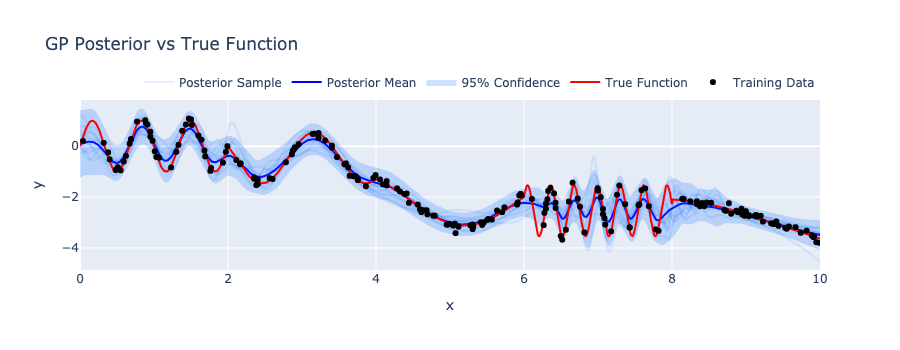

In [8]:
# Plot the predictions

fig = go.Figure()

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=pred_samples[:, i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        )
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=pred_means.flatten(),
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
    )
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([pred_upper, pred_lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
    )
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
    )
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=obs_x.view(-1),
        y=obs_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
    )
)

# Update layout
fig.update_xaxes(range=[0, 10])
fig.update_layout(
    title="GP Posterior vs True Function", xaxis_title="x", yaxis_title="y"
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))

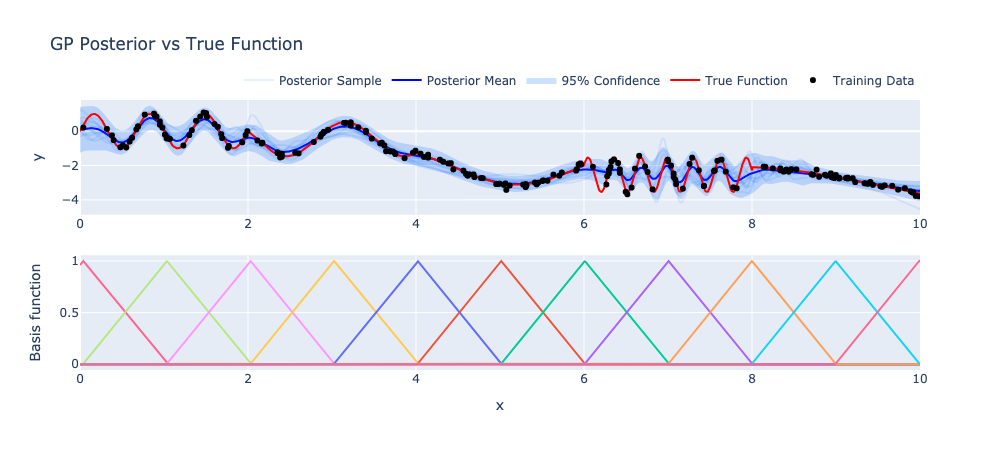

In [9]:
# Plot the posterior results and the basis functions results
fig = subplots.make_subplots(rows=2, cols=1)

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=pred_samples[:, i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        )
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=pred_means.flatten(),
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
    )
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([pred_upper, pred_lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
    )
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
    )
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=obs_x.view(-1),
        y=obs_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
    )
)

# Plot basis functions
for i in range(num_basis):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=basis_functions_true[:, i],
            mode="lines",
            name="Labels",
            legendgroup="labels",
            showlegend=False,
        ),
        row=2,
        col=1,
    )

# Update layout
fig.update_xaxes(range=[0, 10], row=1, col=1)
fig.update_xaxes(range=[0, 10], row=1, col=2)
fig.update_layout(title="GP Posterior vs True Function")
fig.update_xaxes(title_text="x", row=2, col=1)
fig.update_yaxes(title_text="y", row=1, col=1)
fig.update_yaxes(title_text="Basis function", row=2, col=1)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=1000, height=450)))